# EE4483 Mini Project (Option 2): Cats vs Dogs

Name: Melvin Kok Xinwei
Matriculation Number: U1820030C

## Overview
1. Loading data
2. Data processing
3. Model selection
4. Model training
5. Prediction

# Setup environment

In [1]:
import copy
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from pandas.core.common import flatten
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()
separator = os.path.sep

In [3]:
params = {
    # "model": "resnet50",
    # "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "n_epochs": 10,
    "image_size": 256,
    "in_channels": 3,
    "num_classes": 5
}

# 1. Loading data

Place `datasets` in same directory as notebook

In [4]:
# Define main directories
base_dir = "datasets"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [5]:
train_image_paths = []
classes = []

for data_path in glob.glob(train_dir + separator + "*"):
    classes.append(data_path.split(separator)[-1])
    train_image_paths.append(glob.glob(data_path + separator + "*"))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

validation_image_paths = []
classes = []

for data_path in glob.glob(validation_dir + separator + "*"):
    classes.append(data_path.split(separator)[-1])
    validation_image_paths.append(glob.glob(data_path + separator + "*"))

validation_image_paths = list(flatten(validation_image_paths))
random.shuffle(validation_image_paths)

test_image_paths = []
for data_path in glob.glob(test_dir + separator + "*"):
    # test_image_paths.append(glob.glob(data_path + separator + "*"))
    test_image_paths.append(data_path)

test_image_paths = list(flatten(test_image_paths))

print("train_image_path example: ", train_image_paths[0])
print("validation_image_path example: ", validation_image_paths[0])
print("test_image_path example: ", test_image_paths[0])

train_image_path example:  datasets\train\dog\dog.8219.jpg
validation_image_path example:  datasets\val\dog\dog.280.jpg
test_image_path example:  datasets\test\1.jpg


In [6]:
print(f"Classes: {classes}")
print(f"Train size: {len(train_image_paths)}\nValid size: {len(validation_image_paths)}\nTest size: {len(test_image_paths)}")

Classes: ['cat', 'dog']
Train size: 20000
Valid size: 5000
Test size: 500


In [7]:
# Class to index mappings

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [8]:
class CatDogDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split(separator)[-2]
        label = self.class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [9]:
transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((356, 356)),
            transforms.RandomCrop((params["image_size"], params["image_size"])),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
)

In [10]:
train_dataset = CatDogDataset(train_image_paths, class_to_idx, transform)
valid_dataset = CatDogDataset(validation_image_paths, class_to_idx, transform)

# 2. Process data

In [11]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=params["batch_size"], shuffle=True
)

loaders = {'train': train_loader, 'valid': valid_loader}

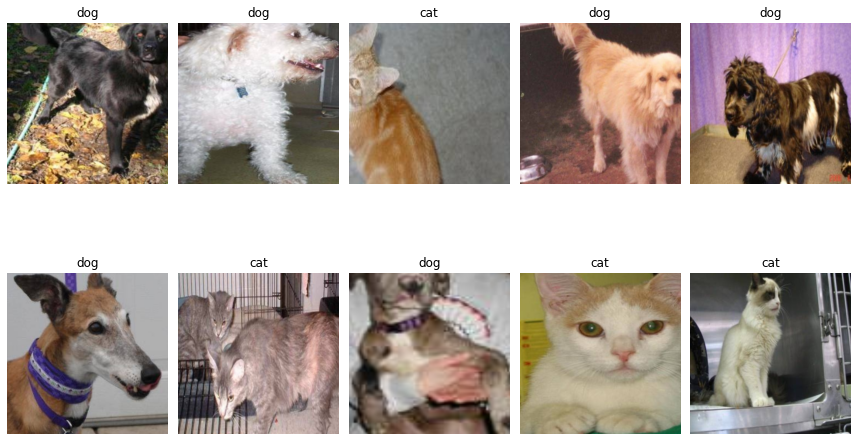

In [12]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img=False):

    dataset = copy.deepcopy(dataset)
    # we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
        ]
    )
    rows = samples // cols

    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()


visualize_augmentations(train_dataset, np.random.randint(
    1, len(train_image_paths)), random_img=True)

# 3. Model selection

In [13]:
model = torchvision.models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

for index, param in enumerate(model.classifier.parameters()):
    if index == 6:
        param.requires_grad = True

model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())
# loss_fn = torch.nn.NLLLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = params['lr'])

In [15]:
train_losses = []
valid_losses = []
for epoch in range(params['n_epochs']):
    # Train
    train_loss = 0.0
    model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description(f"Epoch {epoch+1}/{params['n_epochs']}")

            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss += ((1 / (step + 1)) * (loss.data.item() - train_loss))

            pbar.set_postfix(loss=loss.data.item())
    train_losses.append(train_loss)

    # Validation
    running_loss = 0
    actual_labels = []
    pred_labels = []
    model.eval()
    with tqdm(enumerate(valid_loader), total=len(valid_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description(f"Epoch {epoch+1}/{params['n_epochs']}")  
            imgs, labels = imgs.to(device), labels.to(device)
            log_preds = model(imgs)
            loss = loss_fn(log_preds, labels)

            preds = torch.exp(log_preds)
            running_loss+=((1 / (step + 1)) * (loss.data.item() - running_loss))

            #calculate accuracy
            top_prob, top_class = preds.topk(1, dim=1)
            pred_labels+= list((top_class.view(-1)).cpu().numpy())
            actual_labels+= list(labels.cpu().numpy())

            pbar.set_postfix(loss=loss.data.item())

        correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
        total = len(valid_dataset)
        accuracy = correct / total

        tqdm.write('Epoch {} avg Valid loss: {:.3f}'.format(epoch + 1, running_loss))
        tqdm.write('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(
            epoch + 1, accuracy, correct, total))

    valid_losses.append(running_loss)

    # if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss_fn,
    #         'train_transforms': transform,
    #         'test_transforms': transform,
    #         }, 'checkpoint.tar')

Epoch 1/10: 100%|██████████| 79/79 [00:45<00:00,  1.75batch/s, loss=0.0389]


Epoch 1 avg Valid loss: 0.071
Epoch 1 Valid accuracy: 97.3% (4864 of 5000 right)



Epoch 2/10: 100%|██████████| 79/79 [00:43<00:00,  1.83batch/s, loss=0.000791]


Epoch 2 avg Valid loss: 0.088
Epoch 2 Valid accuracy: 97.1% (4856 of 5000 right)



Epoch 3/10: 100%|██████████| 79/79 [00:43<00:00,  1.83batch/s, loss=0.198]


Epoch 3 avg Valid loss: 0.061
Epoch 3 Valid accuracy: 97.7% (4883 of 5000 right)



Epoch 4/10: 100%|██████████| 79/79 [00:43<00:00,  1.83batch/s, loss=0.162]


Epoch 4 avg Valid loss: 0.071
Epoch 4 Valid accuracy: 97.8% (4888 of 5000 right)



Epoch 5/10: 100%|██████████| 79/79 [00:43<00:00,  1.83batch/s, loss=0.00231]


Epoch 5 avg Valid loss: 0.099
Epoch 5 Valid accuracy: 97.2% (4862 of 5000 right)



Epoch 6/10: 100%|██████████| 79/79 [00:43<00:00,  1.83batch/s, loss=0.276]


Epoch 6 avg Valid loss: 0.118
Epoch 6 Valid accuracy: 95.9% (4796 of 5000 right)



Epoch 7/10: 100%|██████████| 79/79 [00:43<00:00,  1.84batch/s, loss=0.0179]


Epoch 7 avg Valid loss: 0.058
Epoch 7 Valid accuracy: 97.7% (4887 of 5000 right)



Epoch 8/10: 100%|██████████| 79/79 [00:43<00:00,  1.83batch/s, loss=0.0757]


Epoch 8 avg Valid loss: 0.080
Epoch 8 Valid accuracy: 97.3% (4865 of 5000 right)



Epoch 9/10: 100%|██████████| 79/79 [00:42<00:00,  1.84batch/s, loss=0.000234]


Epoch 9 avg Valid loss: 0.066
Epoch 9 Valid accuracy: 97.6% (4881 of 5000 right)



Epoch 10/10: 100%|██████████| 79/79 [00:43<00:00,  1.82batch/s, loss=0.333]

Epoch 10 avg Valid loss: 0.099
Epoch 10 Valid accuracy: 97.2% (4862 of 5000 right)

